# Описание проекта

Интернет-магазин товаров для дома и быта «Пока все ещё тут» хочет выявить профили потребителей для разработки более персонализированных предложений. 

**Задача: сегментировать клиентов на основе истории их покупок**

# Описание данных

Датасет *ecommerce_dataset.csv* описывает транзакции и включает колонки:

- `date` — дата заказа;
- `customer_id` — идентификатор покупателя;
- `order_id` — идентификатор заказа;
- `product` — наименование товара;
- `quantity` — количество товара в заказе;
- `price` — цена товара.

## Импорт библиотек, загрузка и обзор данных

In [1]:
import pandas as pd

import numpy as np

import seaborn as sns

from matplotlib import pyplot as plt

from pymystem3 import Mystem

from collections import Counter

from scipy import stats as st

import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore")

In [2]:
pd.options.display.float_format = '{:,.2f}'.format

In [3]:
try:
    data = pd.read_csv('/Users/olgakirianova/ecommerce_dataset.csv')
    
except:
    data = pd.read_csv('/datasets/ecommerce_dataset.csv')
    

In [4]:
data.sample(n=3)

,date,customer_id,order_id,product,quantity,price
5931,2019072222,22773595-76a0-466b-a7e3-e88997de0c13,72069,Плед флисовый 200х150 см WELLNESS WPL152-Атлан...,3,712.00
6244,2019090314,149c5ba9-f52c-4980-888f-c4e9353edd8f,72494,"Таз пластмассовый 10,0 л пищевой круглый С1212...",1,164.00
5797,2019071010,1441d772-6f55-490f-8edf-171bef655b16,14896,Рассада зелени для кухни Тимьян-чабрец розовый...,1,89.00


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         6737 non-null   int64  
 1   customer_id  6737 non-null   object 
 2   order_id     6737 non-null   int64  
 3   product      6737 non-null   object 
 4   quantity     6737 non-null   int64  
 5   price        6737 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 315.9+ KB


В датасете 6 колонок, 6737 строк. Формат даты *int* требует корректировки в *datetime*, остальные типы данных соответствуют значениям. Одинаковое строк в таблице говорит о том, что пропусков нет, но необходимо проверить датасет на наличие явных и неявных дубликатов. 

## Предобработка

In [6]:
# приведем дату в формат datetime

data['date'] = pd.to_datetime(data['date'], format='%Y%m%d%H') 

In [7]:
# заменим заглавные буквы прописными 

data['product'] = data['product'].str.lower()

In [8]:
# проверим на явные дубликаты 

data.duplicated().sum() 

0

In [9]:
# проверим на пропуски

data.isna().sum()

date           0
customer_id    0
order_id       0
product        0
quantity       0
price          0
dtype: int64

In [10]:
# проверим на неочевидные дубликаты 

dupl = data[data[['customer_id', 'order_id', 'product']].duplicated()]
dupl.head()

,date,customer_id,order_id,product,quantity,price
58,2018-10-02 18:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,доска гладильная eurogold professional 130х48 ...,1,"3,299.00"
59,2018-10-02 19:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,доска гладильная eurogold professional 130х48 ...,1,"3,299.00"
60,2018-10-02 20:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,доска гладильная eurogold professional 130х48 ...,1,"3,299.00"
63,2018-10-03 04:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,доска гладильная eurogold professional 130х48 ...,1,"3,299.00"
94,2018-10-04 13:00:00,32de7df8-8d4f-4c84-a7b9-c41d00dd83ba,68522,эвкалипт гунни d-17 см h-60 см,1,"1,409.00"


In [11]:
dupl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1886 entries, 58 to 6736
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         1886 non-null   datetime64[ns]
 1   customer_id  1886 non-null   object        
 2   order_id     1886 non-null   int64         
 3   product      1886 non-null   object        
 4   quantity     1886 non-null   int64         
 5   price        1886 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 103.1+ KB


In [12]:
# посмотрим на один из возможных дублей заказов
    
data.query('order_id == 68522')

,date,customer_id,order_id,product,quantity,price
80,2018-10-04 09:00:00,32de7df8-8d4f-4c84-a7b9-c41d00dd83ba,68522,эвкалипт гунни d-17 см h-60 см,1,"1,409.00"
94,2018-10-04 13:00:00,32de7df8-8d4f-4c84-a7b9-c41d00dd83ba,68522,эвкалипт гунни d-17 см h-60 см,1,"1,409.00"


In [13]:
# посчитаем, сколько раз встречается номер заказа в датасете с дубликатами

dupl['order_id'].value_counts()

14833    876
14835    174
14753     60
70960     59
14897     37
        ... 
72162      1
68814      1
72914      1
70872      1
69628      1
Name: order_id, Length: 257, dtype: int64

In [14]:
 # посмотрим, что в одном из заказов

dupl.query('order_id == 70960')['product'].value_counts()

сумка-тележка 2-х колесная gimi argo красная    59
Name: product, dtype: int64

In [15]:
# и еще в одном

dupl.query('order_id == 14835')['product'].value_counts()

калибрахоа aloha kona pineaple желто-красная объем 0,5 л                          6
бакопа ампельная, диам. 12 см                                                     6
калибрахоа mini famous double blue фиолетовая махровая объем 0,5 л                6
вербена white blue сиренево-белая объем 0,5 л                                     6
бакопа ампельная мега-крупная сиреневая объем 0,5 л                               6
калибрахоа ампельная, диам. 12 см                                                 6
бакопа ампельная мега-крупная синяя объем 0,5 л                                   6
вербена крупноцветковая white белая объем 0,5 л                                   6
бакопа ампельная махровая фиолетовая махровая объем 0,5 л                         6
петуния surfinia doble lilac светло-сиреневая махровая объем 0,5 л                6
бакопа ампельная махровая белая махровая объем 0,5 л                              6
калибрахоа sweet bells double golden желтая махровая объем 0,5 л            

Совпадают id покупателя, id заказа с наименованием товара, количеством и ценой, различается только время. Всего 1886 неполных дубликатов. В описании датасета указано, что он включает данные о транзакциях, а значит это завершенные операции, а не логи событий. Например магазин мог провести заказ, но у клиента не оказалось достаточной суммы на банковской карте и операция была отклонена, поэтому потом он повторил тот же отмененный заказ и уже оплатил его. Логично, если это только две строчки. В этом варианте будет разумно удалить дубликаты, оставив только одну транзакцию как заверешенный и оплаченный заказ. 

Также это могут быть оптовики/перекупщики, которые по какой-то причине заказывают по одной штуке вместо целой партии, как это может быть в заказе с 59 сумками-тележками. А еще есть похожие на оптовые закупки крупные заказы с рассадой и т.д, но они также содержат повторы. Клиенту гораздо проще закупить всю нужную партию сразу, чтобы отслеживать ее в дальнейшем, чем несколько раз повторять тот же запрос. В любом случае это выглядит аномальным, возможные повторные оптовые закупки от дублей отделить сложно, поэтому несмотря на внушительное количество, от дубликатов лучше избавиться, чтобы не засорять результат.

In [16]:
data_clear = data.drop_duplicates(
    subset=['customer_id', 'order_id', 'product']).reset_index(drop=True) 

data_clear.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4851 entries, 0 to 4850
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         4851 non-null   datetime64[ns]
 1   customer_id  4851 non-null   object        
 2   order_id     4851 non-null   int64         
 3   product      4851 non-null   object        
 4   quantity     4851 non-null   int64         
 5   price        4851 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 227.5+ KB


In [17]:
lost = len(data['order_id']) - len(data_clear['order_id'])

print('Потеря данных после удаления дубликатов: {:.2%}'.format(lost / len(data['order_id']))) 

Потеря данных после удаления дубликатов: 27.99%


Явных дубликатов и пропусков не обнаружено, формат даты приведен к datetime в виде "год-месяц-число-час", минуты и секунды в данном случае значения не имеют. Обнаружено 1886 неявных дубликатов - повторов одними и теми же клиентами одинаковых по составу,стоимости и количеству заказов, но в разное время. Характер появления этих дублей до конца неясен, отличить их от возможных оптовых закупок не представляется возможным, поэтому было принято решение удалить эти строки. Мы потеряли почти 28% данных, это весомое количество, но зато можем быть уверены в чистоте оставшегося датасета.

## Расчет и добавление данных

In [18]:
# перезапишем очищенный датасет для удобства

ecom = data_clear

In [19]:
# добавим колонку с подсчетом общей стоимости заказа

ecom['total'] = ecom['quantity'] * ecom['price']

In [20]:
# посмотрим, за какой период есть данные

print('Минимальная дата: {}'. format(ecom['date'].min())) 
print('Максимальная дата: {}'.format(ecom['date'].max()))

Минимальная дата: 2018-10-01 00:00:00
Максимальная дата: 2019-10-31 14:00:00


Данные представлены за период 13 месяцев с 1 октября 2018 по 31 октября 2019, а значит надо вычленить не только месяц, но и год

In [21]:
ecom['day_of_week'] = ecom['date'].dt.day_name()
ecom['month'] = ecom['date'].dt.month_name()
ecom['year'] = ecom['date'].dt.year
ecom['hour'] = ecom['date'].dt.hour

In [22]:
ecom.tail()

,date,customer_id,order_id,product,quantity,price,total,day_of_week,month,year,hour
4846,2019-10-31 11:00:00,f17ed857-178e-45e1-a662-0a9dd3b58c5f,73155,мимоза стыдливая d-9 см,1,329.00,329.00,Thursday,October,2019,11
4847,2019-10-31 11:00:00,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,73156,"таз пластмассовый 40,0 л пищевой овальный (иж)...",1,404.00,404.00,Thursday,October,2019,11
4848,2019-10-31 12:00:00,1f0a7f35-7459-4f23-b468-5e45bf481dd1,73158,сумка-тележка 2-х колесная gimi argo синяя,1,"1,087.00","1,087.00",Thursday,October,2019,12
4849,2019-10-31 13:00:00,25df96a7-c453-4708-9cea-a3dfc7c342ea,73162,герань домашняя (пеларгония зональная) цветуща...,1,157.00,157.00,Thursday,October,2019,13
4850,2019-10-31 14:00:00,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,73164,"таз пластмассовый со стиральной доской (иж), 1...",1,397.00,397.00,Thursday,October,2019,14


Добавили колонку с общей стоимостью заказа, а также выделили в отдельные колонки часы, день недели, месяц и год для дальнейшего EDA

## Исследовательский анализ данных

In [23]:
# посмотрим на числовое описание количественных колонок

ecom[['quantity', 'price', 'total']].describe()

,quantity,price,total
count,"4,851.00","4,851.00","4,851.00"
mean,2.83,516.06,851.50
std,17.64,946.10,"9,829.37"
min,1.00,9.00,9.00
25%,1.00,90.00,120.00
50%,1.00,150.00,194.00
75%,1.00,502.00,734.00
max,"1,000.00","14,917.00","675,000.00"


Среднее количество товаров в заказе составляет 2.8 единицы, а средняя цена за штуку в районе 500 рублей. Большое стандартное отклонение во всех колонках говорит о том, что есть выбросы, нужно посмотреть на распределение кол-ва единиц, цены и общей стоимости заказа.

In [24]:
'Количество покупателей в датасете: {}'.format(ecom['customer_id'].nunique())

'Количество покупателей в датасете: 2451'

In [25]:
'Количество заказов в датасете: {}'.format(ecom['order_id'].nunique())

'Количество заказов в датасете: 2784'

In [26]:
'Среднее количество заказов на одного покупателя: {:.2}'.format(
    ecom['order_id'].count() / ecom['order_id'].nunique())

'Среднее количество заказов на одного покупателя: 1.7'

In [27]:
# посмотрим на топ-10 покупателей по числу совершенных заказов

top_customers = ecom.groupby('customer_id').agg(
    {'order_id': 'nunique'}).reset_index().rename(
    columns={'order_id': 'total_orders'}).sort_values(
    by='total_orders', ascending=False)

top_customers.head(10)

,customer_id,total_orders
1916,c971fb21-d54c-4134-938f-16b62ee86d3b,126
742,4d93d3f6-8b24-403b-a74b-f5173e40d7db,35
1101,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,17
1748,b7b865ab-0735-407f-8d0c-31f74d2806cc,7
17,0184f535-b60a-4914-a982-231e3f615206,5
1820,bea7a833-2074-42db-bc49-4457abd3c930,4
2147,e0535076-6270-4df2-8621-cb06264a94fa,4
699,498f12a4-6a62-4725-8516-cf5dc9ab8a3a,4
1184,7d0641a6-e043-487d-b356-38895fe7df84,3
2307,f163e581-59ba-4022-99db-e0973c7497c0,3


In [28]:
# посчитаем, сколько раз оформлял заказ каждый покупатель

count_orders = top_customers.groupby('total_orders').agg(
    {'customer_id': 'nunique'}).rename(
    columns={'customer_id': 'count'}).reset_index().set_index('total_orders')

count_orders

,count
total_orders,
1,2291
2,132
3,20
4,3
5,1
7,1
17,1
35,1
126,1


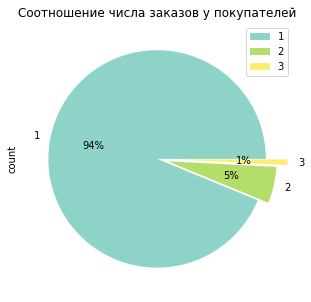

In [29]:
count_orders.query('total_orders < 4').plot(
    y='count', kind='pie', autopct = '%.0f%%', 
    figsize=(5, 5), colormap='Set3', explode=(0,0.1,0.2))
plt.title('Соотношение числа заказов у покупателей')
plt.show()

На одного покупателя приходится в среднем 1.7 заказов, но после группировки клиентов по количеству оформленных заказов видно, что на этот результат влияют три покупателя с очень большим количеством транзакций. На самом деле 94% клиентов совершали всего одну покупку, и только 5% заказывали что-то дважды. Нужно срочно принимать меры по конвертации разовых покупателей в постоянных.


In [30]:
# посчитаем, сколько заказов содержат больше 1 единицы товара

cross = ecom.groupby('order_id').agg(
    {'product': 'count'}).sort_values(by='product', ascending=False)

print(len(cross.query('product > 1')))
print(len(cross.query('product > 1')) / (ecom['order_id'].nunique()) * 100)

430
15.445402298850574


Всего 430 из 2784, а это примерно 15% - то есть помимо большого количества одноразовых покупателей они еще и заказывают в основном не более 1 вида товара. Налицо проблема с дополнительными и кросс-продажами.

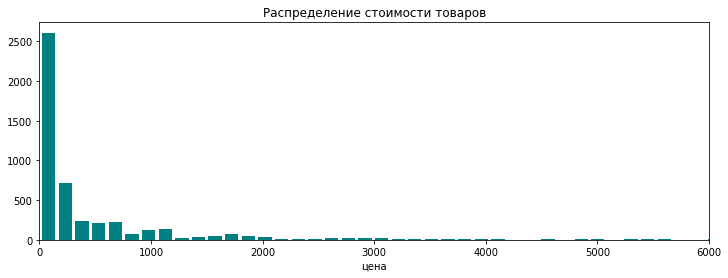

In [31]:
plt.figure(figsize = (12, 4))
ecom['price'].hist(bins=100, grid=False, rwidth=0.8, color='teal')
plt.xlabel('цена')
plt.title('Распределение стоимости товаров')
plt.xlim(0, 6000)
plt.show()

In [32]:
# посмотрим на товары выше 10000 за штуку

ecom.query('price > 10000')

,date,customer_id,order_id,product,quantity,price,total,day_of_week,month,year,hour
4197,2019-07-29 17:00:00,0d87f4ae-465a-4fac-81e6-5d629761783e,72139,сушилка уличная leifheit 85210 linomatic v 400...,1,"14,917.00","14,917.00",Monday,July,2019,17


In [33]:
# сгруппируем заказы по числу единиц

top_orders = ecom.groupby('order_id').agg(
    {'quantity': 'sum'}).reset_index().sort_values(
    by='quantity', ascending=False)


top_orders.head()

,order_id,quantity
2045,71743,1000
2008,71668,334
1912,71478,300
405,68611,300
800,69289,200


In [34]:
# посчитаем, как распределяются заказы по числу единиц в них

count_item = top_orders.groupby('quantity').agg(
    {'order_id': 'count'}).rename(columns={
    'order_id': 'count'
}).reset_index()

count_item.head(10)


,quantity,count
0,1,1770
1,2,274
2,3,131
3,4,99
4,5,66
5,6,51
6,7,31
7,8,30
8,9,23
9,10,71


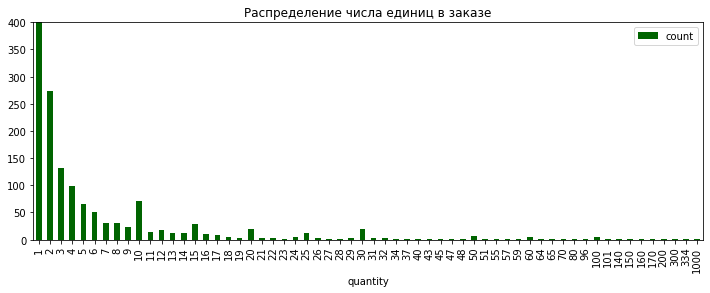

In [35]:
ax = count_item.plot.bar(x='quantity', y='count', figsize=(12,4), color='darkgreen')
ax.set_ylim(0, 400)
ax.set_title('Распределение числа единиц в заказе')
plt.show()

In [36]:
# посмотрм, что покупают в количестве более 50 единиц

ecom.query('quantity > 50').groupby('product').agg({'quantity': 'sum'})

,quantity
product,
"вантуз с деревянной ручкой d14 см красный, burstenmann, 0522/0000",1000
вешалки мягкие для деликатных вещей 3 шт шоколад,334
искусственный цветок подснежник садовый пластиковый белый,65
"ковш пластмассовый полимербыт с215, 1,5 л 1406006",59
"крепеж для пружины дверной оцинкованный, 1107054",100
"крепеж для пружины дверной, 1107055",150
кружка с трубочкой attribute мяч 500 мл jar501,60
"крючок одежный 2-х рожковый серый металлик с полимерным покрытием *тонар*, 1110027",96
муляж яблоко 9 см красное,610


Более 60% покупателей имеют только одну единицу товара в чеке. Видны всплески, с шагом 5-10 единиц, то есть заказывают преимущественно кратно этим числам. Большое количество единиц одного наименования в заказе - преимущественно всякая недорогая "мелочевка" вроде крепежных элементов или хозтоваров.

In [37]:
# посмотрим на самые дорогие заказы
ecom.query('total > 50000')

,date,customer_id,order_id,product,quantity,price,total,day_of_week,month,year,hour
3819,2019-06-18 15:00:00,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,71743,"вантуз с деревянной ручкой d14 см красный, bur...",1000,675.00,"675,000.00",Tuesday,June,2019,15


Сушилка уличная почти за 15 тысяч рублей действительно существует, границу между оптом и не оптом провести сложно. 1000 вантузов или 300 муляжей яблок однозначно не розничная покупка, но сто единиц крепежа могут быть приобретены например для строительства дома, а не дальнейшей перепродажи. Оптовые покупатели - тоже покупатели, не будем отделять их от розничных, но удалим данные с 1000 вантузов, так как они слишком выделяются количеством и общей стоимостью и могут исказить распределения.  

In [38]:
# убираем покупалеля 1000 вантузов 

ecom = ecom.query('quantity < 1000')

In [39]:
# посмотрим, как различается число заказов по дням недели

orders_by_day = ecom.groupby('day_of_week').agg(
    {'order_id': 'count'}).reset_index().rename(
    columns={'order_id': 'total_orders'}).sort_values(
    by='total_orders', ascending=False)

orders_by_day

,day_of_week,total_orders
1,Monday,856
5,Tuesday,805
4,Thursday,783
6,Wednesday,715
0,Friday,631
3,Sunday,587
2,Saturday,473


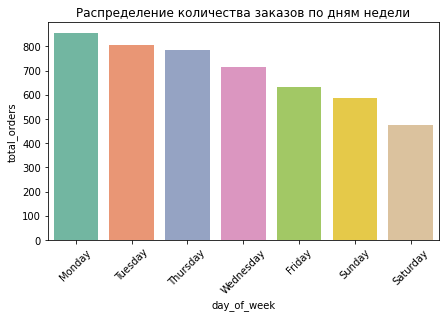

In [40]:
plt.figure(figsize=(7, 4))
ax = sns.barplot(x='day_of_week', 
                 y='total_orders', 
                 data=orders_by_day, 
                 palette='Set2')
plt.xticks(rotation=45)
ax.set_title('Распределение количества заказов по дням недели')
plt.show()

In [41]:
# посмотрим, как различается сумма заказов по дням недели

total_by_day = ecom.groupby('day_of_week').agg(
    {'total': 'sum'}).reset_index().sort_values(
    by='total', ascending=False)

total_by_day

,day_of_week,total
5,Tuesday,"674,306.00"
1,Monday,"579,480.00"
4,Thursday,"547,899.00"
0,Friday,"517,785.00"
6,Wednesday,"509,873.00"
3,Sunday,"366,747.00"
2,Saturday,"259,521.00"


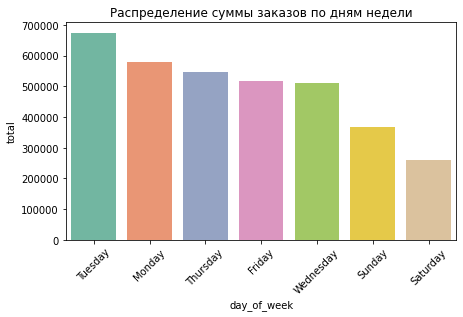

In [42]:
plt.figure(figsize=(7, 4))
ax = sns.barplot(x='day_of_week', 
                 y='total', 
                 data=total_by_day, 
                 palette='Set2')
plt.xticks(rotation=45)
ax.set_title('Распределение суммы заказов по дням недели')
plt.show()

Больше всего заказов приходится на начало недели (возможно в выходные не офрмляется доставка?), а самые дорогие выпадают на вторник. Активность к выходным плавно снижается, суббота - самый провальный день и по количеству, и по сумме. 

In [43]:
# посмотрим, как различается число заказов по времени дня

orders_by_time = ecom.groupby('hour').agg(
    {'order_id': 'count'}).reset_index().rename(
    columns={'order_id': 'total_orders'}).sort_values(
    by='hour')


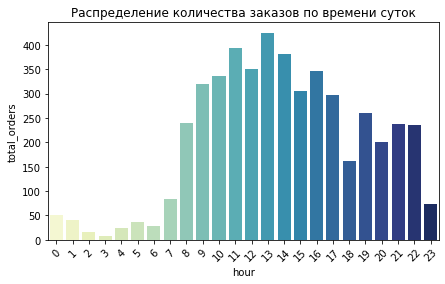

In [44]:
plt.figure(figsize=(7, 4))
ax = sns.barplot(x='hour', 
                 y='total_orders', 
                 data=orders_by_time, 
                 palette='YlGnBu')
plt.xticks(rotation=45)
ax.set_title('Распределение количества заказов по времени суток')
plt.show()

Активность покупателей резко растет с 8 утра и падает только к 6 вечера. Пик наступает в районе полудня, есть небольшой рост вечером, любителей ночного шоппинга совсем мало.   

In [45]:
# посмотрим, как различается число заказов по месяцам

orders_by_month = ecom.groupby(['month', 'year']).agg(
    {'order_id': 'count'}).reset_index().rename(
    columns={'order_id': 'total_orders'}).sort_values(
    by='total_orders', ascending=False)

orders_by_month

,month,year,total_orders
8,May,2019,734
0,April,2019,677
10,October,2018,484
9,November,2018,428
7,March,2019,415
3,February,2019,362
2,December,2018,317
5,July,2019,312
6,June,2019,294
12,September,2019,221


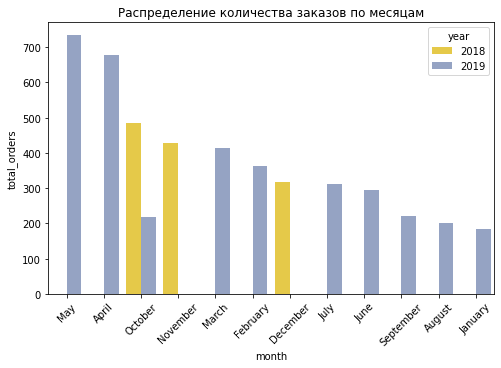

In [46]:
plt.figure(figsize=(8, 5))
ax = sns.barplot(x='month',
                 y='total_orders', 
                 hue='year', 
                 data=orders_by_month, 
                 palette='Set2_r')
plt.xticks(rotation=45)
ax.set_title('Распределение количества заказов по месяцам')
plt.show()

In [47]:
# посмотрим, как различается сумма заказов по месяцам

orders_by_total = ecom.groupby(['month', 'year']).agg(
    {'total': 'sum'}).reset_index().sort_values(
    by='total', ascending=False)

orders_by_total

,month,year,total
9,November,2018,"359,348.00"
2,December,2018,"356,516.00"
10,October,2018,"351,910.00"
0,April,2019,"318,171.00"
3,February,2019,"307,996.00"
7,March,2019,"253,589.00"
8,May,2019,"237,955.00"
4,January,2019,"235,432.00"
5,July,2019,"234,932.00"
6,June,2019,"228,210.00"


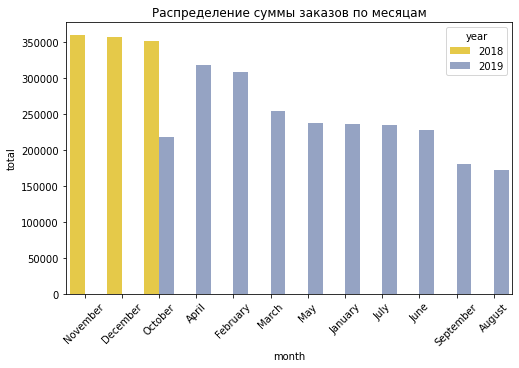

In [48]:
plt.figure(figsize=(8, 5))
ax = sns.barplot(x='month', 
                 y='total', 
                 hue='year', 
                 data=orders_by_total, 
                 palette='Set2_r')
plt.xticks(rotation=45)
ax.set_title('Распределение суммы заказов по месяцам')
plt.show()

На май и апрель 2019 года пришлось самое большое количество заказов - скорей всего это связано с началом садово-огородного сезона. Апрель также был самым продуктивным по выручке, на втором месте - февраль (очевидно, из-за гендерных праздников). А в сентябре, августе и январе того же года заказов было меньше всего, конец лета и начало осени просели и по сумме транзакций. В октябре 2018 было оформлено в два раза больше покупок, и общая стоимость их была выше, чем в 2019 - интересно посмотреть, что на это повлияло. 

**Вывод**

В отфильтрованном датасете 2451 уникальных клиента, 2784 уникальных номера заказа. Один покупатель мог совершить несколько отдельных покупок за выбранный период, а в одном заказе могут быть несколько наименований товаров.

В датасете есть некоторое количество оптовых заказов, из них мы убрали только один наиболее выделяющийся по общей сумме и количеству единиц. Число покупателей, которые совершали аномально много заказов всего трое, их оставили, так как эти данные в итоге не влиют на распределения покупок по дням недели или месяцам.

Среднее число единиц в заказе - 2.8, однако видно, что более 60% клиентов покупают в количестве не более одной единицы, а на среднем сказываются возможные оптовые закупки, либо товары, приобретаемые для личных нужд, но в большом количестве - например, фурнитура и крепежи. Если бы оптовики составляли хотя бы треть датасета их можно было бы выделить сразу в группу и анализировать отдельно. 

Основная часть продуктов магазина - недорогие товары в диапазоне от 9 до 200 рублей, преимущественно заказываются в количестве одной штуки, либо небольшой партией, с шагом в 5-10 единиц, если речь идет о наименованиях, которые обычно приобретают сразу несколько, вроде фурнитуры или рассады.

Активность покупателей выше всего в начале недели и плавно снижается к выходным, в течении дня она держится с 8 утра и примерно до 6 вечера, пиковые часы продаж - в районе полудня. Конец весны - самое продуктивное время, спад продаж в конце лета. Видимо это связано с тем, что больше всего заказывают товаров к началу посадочного сезона, и товары для сада продаются лучше всего. После сегментации по группам товаров проверим, так ли это.



## Категоризация товаров по группам

### Лемматизация

In [49]:
# напишем функцию, которая принимает на вход название товара, а возвращает его леммы:

m = Mystem()

def lemm_func(product_lemm):
    lemm_product = ''.join(m.lemmatize(product_lemm))
    return lemm_product

In [50]:
# применим функцию к столбцу с товарами и добавим новый столбец с леммами 

ecom['product_lemm'] = ecom['product'].apply(lemm_func)


In [51]:
ecom.head()

,date,customer_id,order_id,product,quantity,price,total,day_of_week,month,year,hour,product_lemm
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.00,142.00,Monday,October,2018,0,"комнатный растение в горшок алый вера, d12, h30\n"
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194.00,194.00,Monday,October,2018,0,"комнатный растение в горшок кофе арабика, d12,..."
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.00,112.00,Monday,October,2018,0,радермахер d-12 см h-20 см\n
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179.00,179.00,Monday,October,2018,0,хризолидокарпус лутесценс d-9 см\n
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112.00,112.00,Monday,October,2018,0,циперус зумул d-12 см h-25 см\n


In [52]:
# создадим список с леммами

lemmas = ecom['product_lemm'].to_list()


In [53]:
# с помощью модуля Counter выведем и посчитаем строки с леммами

Counter(lemmas)

Counter({'комнатный растение в горшок алый вера, d12, h30\n': 4,
         'комнатный растение в горшок кофе арабика, d12, h25\n': 2,
         'радермахер d-12 см h-20 см\n': 1,
         'хризолидокарпус лутесценс d-9 см\n': 1,
         'циперус зумул d-12 см h-25 см\n': 10,
         'шеффлер лузеан d-9 см\n': 2,
         'юкка нитчатый d-12 см h-25-35 см\n': 1,
         'настенный сушилка для белье gimi brio super 100\n': 1,
         'таз пластмассовый 21,0 л круглый "водолей" с614, 1404056\n': 1,
         'чехол для гладильный доска colombo persia beige 130х50 см из хлопок 5379\n': 4,
         'вешалка для брюки металлический с резиновый покрытие 26 см цвет: синий, attribute, ahs331\n': 1,
         'сушилка для белье потолочный zalger lift basic 1520 200 см, 10 м\n': 3,
         'чехол eurogold clean basic хлопок для доска 120х38-120х42 см c42\n': 3,
         'крючок одежный 2-х рожковый серый металлик с полимерный покрытие *тонар*, 1110027\n': 1,
         'корзина мягкий пластиковый 

### Категоризация

После анализа списка с леммами было принято решение выделить следующие категории товаров:

**Растения для дома и сада** - семена, черенки, рассада, комнатные растения. Хотя садово-огородные культуры и комнатные растения - две разных группы товаров, но поскольку задача состоит в категоризации покупателей про группам товаров, то логично предположить, что те, у кого есть дача, так же увлекаются разведением домашних растений. И наоборот - помидоры можно выращивать на балконе, не имея дачи.

**Хозтовары для дома и быта** - утилитарные предметы: для стирки, глажки и уборки, хранение, сумки-тележки - товары для дома, которые как правило, выбираются сугубо из практических соображений, а не для украшательства. Бытовую химию тоже запишем в эту категорию.

**Товары для кухни** - все, что предназначено как для готовки, так и сервировки. 

**Декор и текстиль** - товары для интерьера: искусственные цветы, муляжи фруктов и овощей, декоративные предметы, здесь же текстиль для спальни, ванной и кухни. 

**Строительство и ремонт** - различные комплектующие, крепежи, фурнитура, стремянки, инструменты.

**Мебель** - полки, комоды, стеллажи

**Бытовая техника** - мелкая техника для дома и кухни 


In [54]:
# создадим списки с категориями товаров, куда войдут ключевые слова 

garden = ['растение', 'радермахер', 'хризолидокарпус', 'циперус', 'юкка', 'рассада', 'шеффлер', 
          'герань', 'пеларгония', 'суккулент', 'эхеверие', 'эвкалипт', 'адиантум', 'кампануть', 
          'калатея', 'хлорофитум', 'цикламен','глоксиния', 'азалия', 'гортензия', 'хризантема', 
          'мирт', 'кассета', 'иссоп', 'сантолина', 'аспарагус', 'афеляндра', 'антуриум', 'гербера', 
          'душица', 'мелисса', 'роза', 'фиалка', 'бегония', 'розмарин', 'альбук', 'бальзамин', 
          'бегония', 'крассула', 'лаванда', 'мята', 'каланхое', 'примула', 'калоцефалус', 'каллун',
          'капсикум', 'соланум', 'бархатцы', 'морковь', 'настурция', 'огурец', 'петуния', 'алиссум', 
          'гвоздик', 'годеция', 'календула', 'капуста', 'кореопсис', 'косметь', 'апчатка', 'львиный', 
          'флокс', 'цинерария', 'эшшольция', 'диффенбахий', 'фаленопсис', 'подсолнечник', 'пуансетия', 
          'черенок', 'ель', 'кипарисовик', 'аптение', 'пуансеттия', 'скиммия', 'фиттоний','фикус', 
          'молодило', 'тимьян', 'мединилла', 'литопс', 'мимоза', 'нолина', 'полынь', 'пахира', 'лавр',
          'эхинокактус', 'зверобой', 'дендробиум', 'фуксия', 'алоэ вера', 'спатифиллум', 'гимнокалициум',
          'томат', 'укроп', 'рукол', 'чабер', 'арабика', 'крокус', 'гипсофил', 'базилик', 'петрушка', 
          'эпипремнум', 'аквилегия', 'горох', 'земляника', 'незабудка', 'седум', 'нефролепис', 'калла',
          'декабрист', 'тюльпан', 'гиацинт', 'колокольчик', 'калибрахоа', 'ранункулус', 'вербена',
          'замиокулькас', 'амариллис', 'цветок', 'георгин', 'смолевка', 'цинния', 'вербейник', 'котовник',
          'лантана', 'эхинацея', 'ясколка', 'виола', 'клен', 'платикодон', 'лилейник', 'папоротник',
          'платикодон', 'энотера', 'цитрофортунелла', 'пеперомия', 'гардения', 'хемодея', 'хамедорей',
          'тыква', 'дыня', 'лантан', 'гвинея', 'кабачок', 'виноград', 'лобелия', 'горшок', 'пиретрум',
          'кашпо', 'муррайя', 'вероника', 'арбуз', 'баклажан', 'клубника', 'патиссон', 'джункус',
          'драцена', 'фатсия', 'хоста', 'монард', 'нивянник', 'гайлардий', 'рудбекия', 'барвинок', 
          'осина', 'трава', 'астра', 'камнеломка', 'лаватер', 'анемон', 'лен', 'солидаго', 'физостегия',
          'бадан']

In [55]:
household_goods = ['таз', 'чехол', 'вешалка', 'сушилка', 'корзина', 'гладильный',
                   'сумка-тележка', 'щетка-сметка', 'сумка', 'ерш', 'прищепок','кондиционер',
                   'перчатка', 'плечики', 'хранение', 'пятно', 'стиральный', 'щетка', 'мыло',
                   'ванна', 'подрукавник', 'контейнер', 'зубной', 'веник', 'швабра', 'ящик',
                   'ведро', 'короб', 'коробка', 'вешалка-плечики', 'корыто', 'урна', 'унитаз',
                   'обувной', 'средство', 'губка', 'ролик', 'термометр', 'шило', 'мытье', 'сетка',
                   'ополаскиватель', 'вешалка-сушилка', 'вантуз', 'посудомоечный', 'стирка', 'сидение',
                   'подголовник', 'щетка-утюжок', 'антижир', 'сметка', 'кофр', 'чистка', 'совок', 
                   'обувь', 'фал', 'маска', 'окномойка', 'шпагат', 'насадка-моп', 'микрофибры',
                   'антинакипин', 'тряпкодержатель']

In [56]:
kitchen_goods = ['антипригарный', 'сковорода', 'тарелка', 'вилка', 'нож', 'кружка', 'фужер', 'бокал',
                 'кувшин', 'толкушка', 'банка', 'противень', 'посуда', 'ножеточка', 'салатник', 
                 'свисток','чайный', 'рыбочистка', 'терка', 'контейнер', 'лопатка', 'стакан', 'столовый', 
                 'чайный','овощечистка', 'мантоварка', 'ковш', 'ножницы', 'кисточка', 'картофелемялка', 
                 'скребок', 'форма', 'миска', 'лоток', 'чеснок', 'термостакан', 'дуршлаг', 'термос', 
                 'электроштопор','блюдце', 'бульонница', 'разделочный', 'соус', 'мука', 'кастрюля', 
                 'овощеварка', 'столовая', 'чайная', 'масленка', 'термокружок', 'сахарница', 'яйцо', 
                 'половник', 'хлебница', 'свч', 'блюдо', 'орехоколка', 'соковарка', 'соковыжималка', 
                 'пьезозажигалка', 'скалка', 'бидон', 'венчик', 'сито', 'тортница', 'овсянница', 
                 'кондитерский', 'кухонный', 'сотейник', 'кипятильник', 'эмалированный', 'заварочный']

In [57]:
interior = ['муляж', 'коврик', 'дозатор', 'искусственный', 'плед', 'скатерть', 'простыня', 
            'штора', 'подушка', 'полотенце', 'салфетка', 'ковер', 'фоторамка',
            'наматрасник', 'наматрицник-чехол', 'халат', 'салфетница', 'покрывало', 'постельный', 
            'одеяло', 'ключница', 'светильник', 'искуственный', 'подарочный', 'наматрацник', 
            'наволочка', 'пододеяльник', 'корзинка']

In [58]:
tools = ['котел', 'стремянка', 'лестница-стремянка', 'тележка', 'стяжка', 'крючок', 'крепеж', 'пружина',
         'свереть', 'сверло-фреза', 'карниз', 'шнур', 'измерительный', 'линейка', 'бензин', 'полировка',
         'петля-стрела', 'рассекатель', 'ручка-скоба', 'стремянка-табурет', 'инструмент',
         'петля', 'кольцо', 'карниз', 'сварка', 'штанга', 'уголок', 'решетка', 
         'штангенциркуль', 'напильник', 'завертка', 'сверло', 'фиксатор-шар', 'пробка']

In [59]:
furniture = ['полка', 'пуф', 'комод', 'стеллаж', 'обувница-3']

In [60]:
tech = ['миксер', 'фен', 'весы', 'пылесос', 'электрический', 'утюг']

In [61]:
# напишем функцию категоризации товаров по ключевым словам словаря

categories_dict = {'товары для дома и быта': household_goods,
                   'товары для кухни': kitchen_goods,
                   'декор и текстиль': interior,
                   'строительство и ремонт': tools,
                   'мебель': furniture,
                   'бытовая техника': tech,
                   'комнатные и садовые растения': garden}
    
def category(product_lemm):
    for category_name, category_list_items in categories_dict.items():
        for item in category_list_items:
            if item in product_lemm:
                return category_name



# добавим столбец с категориями

ecom['category'] = ecom['product_lemm'].apply(category)

In [62]:
# проверим, что все раскидали по категориям и при необходимости почистим еще

ecom.query('category == "другое"')

,date,customer_id,order_id,product,quantity,price,total,day_of_week,month,year,hour,product_lemm,category


In [63]:
ecom.sample(2)

,date,customer_id,order_id,product,quantity,price,total,day_of_week,month,year,hour,product_lemm,category
1873,2019-03-05 05:00:00,98de0e2a-2e04-48de-a12c-c139394c8da4,14560,декабрист в горшке d12 красный,1,139.00,139.00,Tuesday,March,2019,5,декабрист в горшок d12 красный\n,комнатные и садовые растения
3433,2019-05-24 10:00:00,f9ba8b01-2f9d-493e-ae11-2d470a39502a,14814,рассада капусты белокачанная сорт фаворит касс...,1,120.00,120.00,Friday,May,2019,10,рассада капуста белокачать сорт фаворит кассет...,комнатные и садовые растения


In [64]:
# посмотрим на распределение товаров по категориям 

category = ecom.groupby('category').agg(
    {'product': 'count'}).reset_index().set_index('category').sort_values(
    by='product', ascending=False)

category

,product
category,
комнатные и садовые растения,2477
товары для дома и быта,1289
декор и текстиль,553
товары для кухни,329
строительство и ремонт,153
мебель,27
бытовая техника,22


Мебель и бытовая техника получились самыми малочисленными категориями, однако было правильно выделить их в отдельные группы, так как это достаточно дорогие товары и таким образом они не будут влиять на распределения по цене, как если бы мы записали их в другие группы.
Категория с растениями значительно превосходит остальные по количеству, но было бы довольно сложно отделить садовые культуры от домашних растений, для это бы пришлось постоянно вручную проверять названия в поисковике.

In [65]:
# удалим столбец с леммами

ecom = ecom.drop('product_lemm', axis=1)

ecom.sample()

,date,customer_id,order_id,product,quantity,price,total,day_of_week,month,year,hour,category
76,2018-10-04 09:00:00,32de7df8-8d4f-4c84-a7b9-c41d00dd83ba,68522,эвкалипт гунни d-17 см h-60 см,1,"1,409.00","1,409.00",Thursday,October,2018,9,комнатные и садовые растения


## EDA по категориям товаров

Посмотрим, как распределяется объем всех заказов по категориям, сколько уникальных покупателей в каждой группе, сколько в среднем единиц они заказывают в каждой категории, а также сумму среднего чека для разных групп товаров.

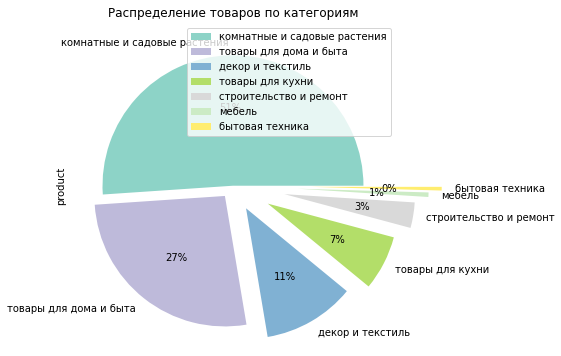

In [66]:
# посмотрим, какой объем товаров в каждой категории

explode = (0,0.1,0.2,0.3,0.4,0.5,0.6)
category.plot(y='product', 
              kind='pie', 
              autopct = '%.0f%%', 
              figsize=(6, 6), 
              colormap='Set3', 
              explode=explode)
plt.title('Распределение товаров по категориям')
plt.show()

Комнатные и садовые растения составляют половину всех наименований товаров, туда же входят саженцы, семена и черенки, это все недорогие позиции, поэтому их часто заказывают. На втором месте хозяйственно-бытовые товары. Декор и все для кухни на третьем и четвертом месте соответственно. Строительных товаров покупают совсем мало. Мебель и бытовая техника - совсем не специализация магазина, даже интересно, почему покупатели выбрали заказать здесь, а не в профильных магазинах.

In [67]:
# посмотрим, сколько покупателей в разных категориях

customers_by_category = ecom.groupby('category').agg(
    {'customer_id': 'nunique'}).rename(
    columns={'customer_id':'number_of_customers'}).reset_index().sort_values(
    by='number_of_customers',ascending=False).set_index('category')

customers_by_category

,number_of_customers
category,
товары для дома и быта,1032
комнатные и садовые растения,658
декор и текстиль,408
товары для кухни,262
строительство и ремонт,131
мебель,25
бытовая техника,18


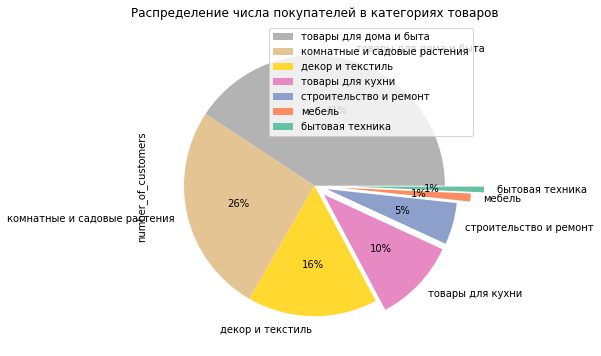

In [68]:
# посмотрим покупателей по категориям в долях

explode = (0,0,0,0.1,0.1,0.2,0.3)
customers_by_category.plot(y='number_of_customers', 
                           kind='pie', autopct = '%.0f%%', 
                           figsize=(6, 6), 
                           colormap='Set2_r',
                           explode=explode)
plt.title('Распределение числа покупателей в категориях товаров')
plt.show()

In [69]:
# посчитаем, сколько было сделано заказов в каждой категории 

ecom.groupby(['category']).agg(
    {'order_id': 'nunique'}).reset_index().sort_values(
    by='order_id', ascending=False)

,category,order_id
5,товары для дома и быта,1176
2,комнатные и садовые растения,750
1,декор и текстиль,450
6,товары для кухни,273
4,строительство и ремонт,146
3,мебель,27
0,бытовая техника,20


Соотношение количества покупателей и количества заказов в каждой категории не сильно отличаются, это означает, что число повторных заказов плюс-минус одинаковое во всех товарных группах. То есть одинаково плохое. В категории кухонных товаров например 95% заказов совершены разными клиентами, в категории хозяйственных и растений ситуация незначительно лучше - 87% покупок сделаны разными людьми. Доля повторных покупателей во всех категориях печально мала.

In [70]:
# посчитаем, сколько денег принесла каждая категория

category_by_total = ecom.groupby('category').agg(
    {'total': 'sum'}).reset_index().set_index('category').sort_values(
    by='total', ascending=False)

category_by_total

,total
category,
товары для дома и быта,"1,851,367.00"
декор и текстиль,"547,111.00"
комнатные и садовые растения,"515,256.00"
товары для кухни,"256,628.00"
строительство и ремонт,"195,085.00"
мебель,"67,452.00"
бытовая техника,"22,712.00"


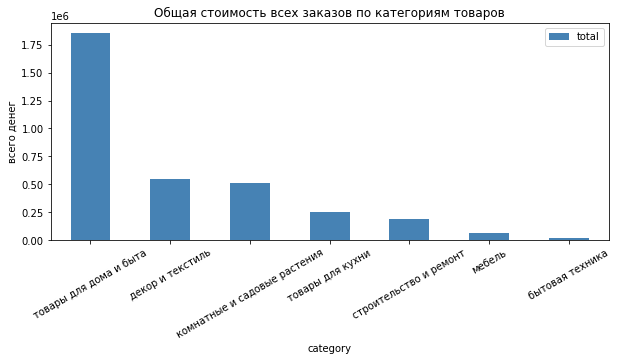

In [71]:
ax = category_by_total.plot.bar(figsize=(10, 4), color='steelblue')
ax.set_title('Общая стоимость всех заказов по категориям товаров')
plt.ylabel('всего денег')
plt.xticks(rotation=30)
plt.show()

40% клиентов покупают в категории "товары для дома и быта", это самая многочисленная группа, она же и приносит большего всего денег, причем со значительным отрывом. Получается, что основу ассортимента магазина составляют растения, а покупают в основном хозяйственные товары. Декор и текстиль, а также растения приносят практически одинаковое количество выручки, при том, что покупатели садовых и комнатных цветов составляют 1/4 часть клиентов, а покупатели в разделе декор и текстиль - только 1/6. А вот выручка в категории товаров для кухни и для строительства соизмерима с их объемами.

In [72]:
# посчитаем товары по категориям с учетом распределения по единицам в заказах

category_by_quantity = ecom.groupby('category').agg(
    {'quantity': 'sum'}).reset_index().set_index('category').sort_values(
    by='quantity', ascending=False)

category_by_quantity

,quantity
category,
комнатные и садовые растения,3729
товары для дома и быта,3293
декор и текстиль,3176
строительство и ремонт,1336
товары для кухни,1160
мебель,30
бытовая техника,22


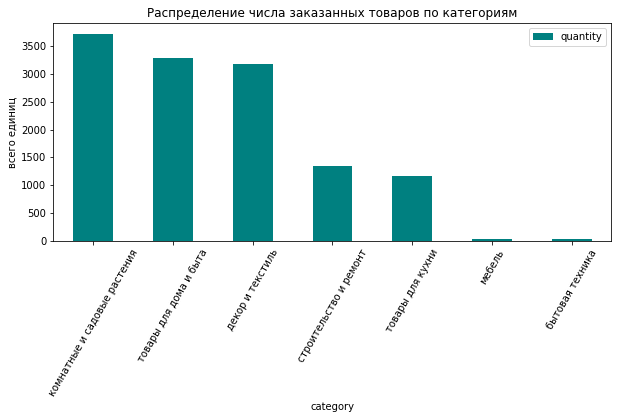

In [73]:
ax = category_by_quantity.plot.bar(figsize=(10,4), color='teal')
ax.set_title('Распределение числа заказанных товаров по категориям')
plt.ylabel('всего единиц')
plt.xticks(rotation=60)
plt.show()

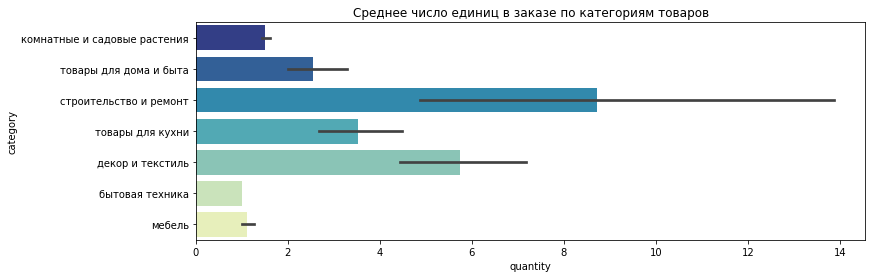

In [74]:
# посмотрим среднее количество единиц в заказе

ax = plt.subplots(figsize=(12, 4))
ax = sns.barplot(data=ecom, y='category', x='quantity', palette='YlGnBu_r')
ax.set_title('Среднее число единиц в заказе по категориям товаров')
plt.show()

Интересно, что среднее количество единиц растений в заказе около 2х штук, при этом их покупают чаще всего. То есть в целом довольно много, но практически поштучно. А вот в категории строительство берут небольшими партиями - видимо мелкие детали и фурнитуру, но всего было продано почти 1500 единиц, в 3 раз меньше, чем в категории растения. Декор и текстиль покупают примерно в количестве 6 единиц, но есть подозрение, что виноваты закупки муляжей фруктов и овощей, именно они влияют на среднее. Хозтоваров было заказано более 3000 единиц, они на втором месте по популярности после растений, но при этом в среднем их кладут около 3шт в заказ.

In [75]:
# посмотрим на топ-товаров по количеству проданных единиц

top_by_units = ecom.groupby(['product', 'category']).agg(
    {'quantity': 'count'}).sort_values(by='quantity', ascending=False)

top_by_units.head(10)

,,quantity
product,category,
пеларгония розебудная red pandora укорененный черенок,комнатные и садовые растения,66
пеларгония розебудная prins nikolai укорененный черенок,комнатные и садовые растения,57
пеларгония зональная диам. 12 см сиреневый полумахровый,комнатные и садовые растения,52
сумка-тележка 2-х колесная gimi argo синяя,товары для дома и быта,47
пеларгония розебудная mary укорененный черенок,комнатные и садовые растения,39
пеларгония розебудная queen ingrid укорененный черенок,комнатные и садовые растения,30
пеларгония розебудная margaretha укорененный черенок,комнатные и садовые растения,29
пеларгония зональная диам. 12 см коралловая полумахровая,комнатные и садовые растения,24
пеларгония зональная махровая лососевая,комнатные и садовые растения,24


In [76]:
# посмотрим на топ-товаров по сумме продаж

top_by_sum = ecom.groupby(['product', 'category']).agg(
    {'total': 'sum'}).sort_values(by='total', ascending=False)

top_by_sum.head(10)

,,total
product,category,
простынь вафельная 200х180 см wellness rw180-01 100% хлопок,декор и текстиль,"53,232.00"
сумка-тележка 2-х колесная gimi argo синяя,товары для дома и быта,"50,405.00"
вешалки мягкие для деликатных вещей 3 шт шоколад,товары для дома и быта,"49,596.00"
тележка багажная delta тбр-22 синий грузоподъемность 20 кг сумка и 50 кг каркас россия,товары для дома и быта,"33,992.00"
муляж яблоко 9 см красное,декор и текстиль,"32,702.00"
набор ножей attribute chef 5 предметов akf522,товары для кухни,"29,248.00"
"сумка-тележка хозяйственная andersen scala shopper plus, lini, синяя 133-108-90",товары для дома и быта,"28,045.00"
"урна уличная ""гео"", hobbyka/хоббика, 59*37,5см, сталь",товары для дома и быта,"24,370.00"
"веник сорго с деревянной ручкой с 4-мя швами, rozenbal, r206204",товары для дома и быта,"20,010.00"


В рейтинге по единицам - 9 из 10 пелагорний из категории растения для дома и сада, интересно, в чем причина такой популярности среди всех остальных цветов. Также в список попала сумка-тележка, она и по сумме продаж также в топе. В списке самых продаваемых товаров по сумме чека в основном те, что закупались в больших количествах одним пользователем. Нужно посмотреть, как распределяются крупные закупки по категориям и в какой группе товаров больше возможных оптовиков, видимо они и приносят основной доход магазину.

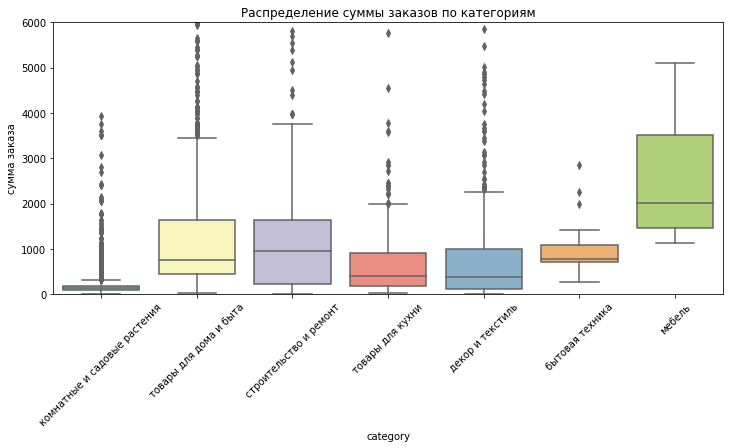

In [77]:
# посмотрим на среднюю стоимость заказа по категориям 

plt.figure(figsize=(12, 5))

ax = sns.boxplot(y='total', x='category', data=ecom, palette='Set3')
plt.title('Распределение суммы заказов по категориям')
plt.ylim(0, 6000)
plt.xticks(rotation=45)
plt.ylabel('сумма заказа')
plt.show()

Если бы средний чек в растениях был выше, можно было бы сказазать, что магазин специализируется на категории сад-огород, об этом говорит и широкий ассортимент. Растений покупают много, но при этом средняя стоимость заказа гораздо меньше по сравнению с другими категориями. Как уже было сказано выше, это напрямую связано с маленьким количеством позиций в корзине покупателя. Основную часть денег магазину приносят хозяйственные товары для дома и быта - на это влияют дорогие позиции вроде сушилок и сумок-тележек. Самый высокий прайс заказа у мебели, но из-за малого числа единиц на выручку они почти не влияют.

#### Сегментация покупателей  по среднему чеку

Для сегментации клиентов возьмем за основу общую сумму заказа и поделим их на группы. Однако как мы видим из анализа выше, средний чек сильно разнится для категорий, поэтому поделим клиентов внутри каждой товарной категории.

Ориентируясь на график распределения суммы заказа по группам товаров, выделим следующие категории для среднего чека:

*Комнатные и садовые растения:*
- до 100 - маленький чек
- от 100 до 200 - средний чек
- от 200 до 300 - выше среднего
- от 300 - крупный чек

*Товары для дома и быта:*
- до 400 - маленький чек
- от 400 до 1800 - средний чек
- от 1800 до 3500 - выше среднего
- от 3500 - крупный чек

*Строительство и ремонт:*
- до 200 - маленький чек
- от 200 до 1700 - средний чек
- от 1700 до 3800 - выше среднего
- от 3800 - крупный чек

*Товары для кухни:*
- до 200 - маленький чек
- от 200 до 900 - средний чек
- от 900 до 2000 - выше среднего
- от 2000 - крупный чек

*Декор и текстить*
- до 100 - маленький чек
- от 100 до 1000 - средний чек
- от 1000 до 1500 - выше среднего
- от 1500 - крупный чек

In [78]:
# запишем категории по отдельным переменным

plants = ecom.query('category == "комнатные и садовые растения"')

house = ecom.query('category == "товары для дома и быта"')

decor = ecom.query('category == "декор и текстиль"')

kitchen = ecom.query('category == "товары для кухни"')

repair = ecom.query('category == "строительство и ремонт"')

In [79]:
# добавим столбец с категорией среднего чека для растений

def purchase(total):
    if total <= 100:        
        return 'маленький'        
    if total > 100 and total <= 200:
        return 'средний'
    if total > 300:
        return 'высокий'
    else:
        return 'выше среднего'

plants['purchase'] = plants['total'].apply(purchase)

In [80]:
# для товаров для дома и быта

def purchase(total):
    if total <= 400:        
        return 'маленький'        
    if total > 400 and total <= 1800:
        return 'средний'
    if total > 3500:
        return 'высокий'
    else:
        return 'выше среднего'

house['purchase'] = house['total'].apply(purchase)

In [81]:
# для строительства и ремонта

def purchase(total):
    if total <= 200:        
        return 'маленький'        
    if total > 200 and total <= 1700:
        return 'средний'
    if total > 3800:
        return 'высокий'
    else:
        return 'выше среднего'

repair['purchase'] = repair['total'].apply(purchase)

In [82]:
# для кухонных товаров

def purchase(total):
    if total <= 200:        
        return 'маленький'        
    if total > 200 and total <= 900:
        return 'средний'
    if total > 2000:
        return 'высокий'
    else:
        return 'выше среднего'

kitchen['purchase'] = kitchen['total'].apply(purchase)

In [83]:
# для декора и текстиля

def purchase(total):
    if total <= 100:        
        return 'маленький'        
    if total > 100 and total <= 1000:
        return 'средний'
    if total > 1500:
        return 'высокий'
    else:
        return 'выше среднего'

decor['purchase'] = decor['total'].apply(purchase)

#### Комнатные и садовые растения

In [84]:
# посмотрим, сколько покупателей по категориям чеков

purchase_plants = plants.groupby('purchase').agg(
    {'customer_id': 'nunique'}).rename(
    columns={'customer_id': 'count'}).sort_values(by='count', ascending=False)

purchase_plants

,count
purchase,
средний,412
высокий,211
маленький,171
выше среднего,103


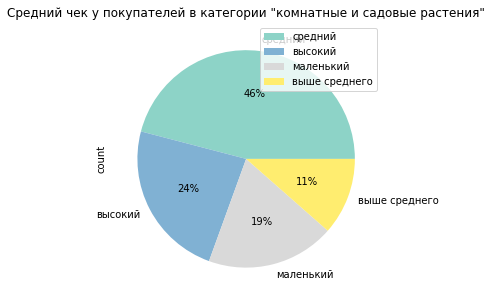

In [85]:
purchase_plants.plot(y='count', kind='pie', 
                     autopct = '%.0f%%', 
                     figsize=(5, 5), colormap='Set3')
plt.title('Средний чек у покупателей в категории "комнатные и садовые растения"')
plt.show()    

In [86]:
# посчитаем, сколько тотал выручки по категориям чеков

plants.groupby('purchase').agg({'total': 'sum'}).reset_index()

,purchase,total
0,высокий,"236,510.00"
1,выше среднего,"39,550.00"
2,маленький,"41,240.00"
3,средний,"197,956.00"


Чуть меньше половины - 46% покупателей в категории "растения для дома и сада" имеют средний чек, у четверти клиентов высокий чек, и эта группа принесла больше всего денег. Все это могло бы выглядеть довольно позитивно, но мы помним, что высокий чек в этой категории составляет всего от 300р, из-за низкой стоимости растений и в среднем двух единиц в заказе. Пятая часть всех совершивших заказ имеют маленький чек, то есть приобрели товаров менее, чем на 100 рублей.  

#### Товары для дома и быта

In [87]:
# количество покупателей по категориям чеков

purchase_house = house.groupby('purchase').agg(
    {'customer_id': 'nunique'}).rename(
    columns={'customer_id': 'count'}).sort_values(by='count', ascending=False)

purchase_house

,count
purchase,
средний,611
маленький,216
выше среднего,149
высокий,96


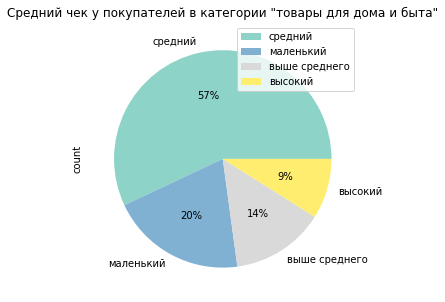

In [88]:
purchase_house.plot(y='count', kind='pie', 
                     autopct = '%.0f%%', 
                     figsize=(5, 5), colormap='Set3')
plt.title('Средний чек у покупателей в категории "товары для дома и быта"')
plt.show()   

In [89]:
# сумма выручки по категориям чеков

house.groupby('purchase').agg({'total': 'sum'}).reset_index()

,purchase,total
0,высокий,"698,232.00"
1,выше среднего,"437,693.00"
2,маленький,"58,934.00"
3,средний,"656,508.00"


In [90]:
# посмотрим, сколько клиентов и на какую сумму купили топ-5 товаров в этой категории

house.pivot_table(index ='product',aggfunc={'customer_id': 'nunique', 
                                           'quantity': 'sum', 'total': 'sum'}).sort_values(
    by='total', ascending=False).head()


,customer_id,quantity,total
product,,,
сумка-тележка 2-х колесная gimi argo синяя,43,47,"50,405.00"
вешалки мягкие для деликатных вещей 3 шт шоколад,2,335,"49,596.00"
тележка багажная delta тбр-22 синий грузоподъемность 20 кг сумка и 50 кг каркас россия,3,59,"33,992.00"
"сумка-тележка хозяйственная andersen scala shopper plus, lini, синяя 133-108-90",5,5,"28,045.00"
"урна уличная ""гео"", hobbyka/хоббика, 59*37,5см, сталь",1,5,"24,370.00"


Больше всего покупателей различных товаров для дома и быта в категории средний чек - 57%, и они принесли почти столько же денег, как и покупатели с высоким. Всего десятая часть имеют крупный чек - в основном те, кто делал оптовые закупки - это видно из таблицы выше. В этой категории клиенты заказывали сумки-тележки партией и в розницу, эти позиции и принесли основную выручку. Пятая часть всех покупателей имеют маленький чек, то есть заказывали на сумму менее 400р - это всякая хозяйственная мелочь типа ложек для обуви и насадок для мытья.   

#### Декор и текстиль

In [91]:
# группируем по количеству покупателей

purchase_decor = decor.groupby('purchase').agg(
    {'customer_id': 'nunique'}).rename(
    columns={'customer_id': 'count'}).sort_values(by='count', ascending=False)

purchase_decor

,count
purchase,
средний,239
высокий,85
маленький,73
выше среднего,39


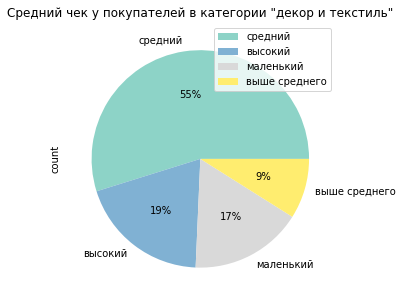

In [92]:
purchase_decor.plot(y='count', kind='pie', 
                     autopct = '%.0f%%', 
                     figsize=(5, 5), colormap='Set3')
plt.title('Средний чек у покупателей в категории "декор и текстиль"')
plt.show() 

In [93]:
# сумма выручки по категориям чеков

decor.groupby('purchase').agg({'total': 'sum'}).reset_index()

,purchase,total
0,высокий,"363,479.00"
1,выше среднего,"50,313.00"
2,маленький,"6,505.00"
3,средний,"126,814.00"


In [94]:
# посмотрим, сколько клиентов и на какую сумму купили топ-5 товаров в категории декор и текстиль

decor.pivot_table(index ='product',aggfunc={'customer_id': 'nunique', 
                                            'quantity': 'sum', 'total': 'sum'}).sort_values(
    by='total', ascending=False).head()

,customer_id,quantity,total
product,,,
простынь вафельная 200х180 см wellness rw180-01 100% хлопок,1,30,"53,232.00"
муляж яблоко 9 см красное,6,618,"32,702.00"
муляж яблоко зеленый 9 см полиуретан,10,308,"17,572.00"
коврик придверный attribute nature кокосовый 60x40 см amc015,4,54,"16,888.00"
салфетка protec textil polyline 30х43 см аметист белая 6230,4,80,"15,700.00"


Пятая часть покупателей имеют высокий чек в этой категории, но как видно из сводной таблицы выше, это все оптовые покупатели муляжей и текстиля, они и сделали основную часть денег. Больше половины - 55% в категории средний чек, то есть это покупки не более 1000 рублей и всего 9% тех, кто оформил заказ на 1000-1500. Целых 17% имеют маленький чек, и выручка в этой группе крайне мала.

#### Товары для кухни

In [95]:
# считаем количество покупателей по категориям

purchase_kitchen = kitchen.groupby('purchase').agg(
    {'customer_id': 'nunique'}).rename(
    columns={'customer_id': 'count'}).sort_values(by='count', ascending=False)

purchase_kitchen

,count
purchase,
средний,121
маленький,72
выше среднего,59
высокий,20


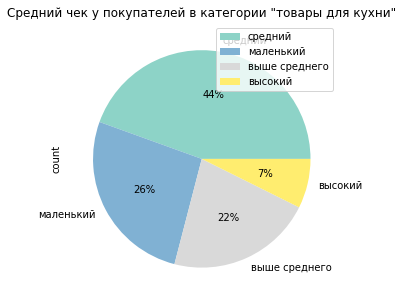

In [96]:
purchase_kitchen.plot(y='count', kind='pie', 
                     autopct = '%.0f%%', 
                     figsize=(5, 5), colormap='Set3')
plt.title('Средний чек у покупателей в категории "товары для кухни"')
plt.show() 

In [97]:
# сумма выручки по категориям чеков

kitchen.groupby('purchase').agg({'total': 'sum'}).reset_index()

,purchase,total
0,высокий,"94,370.00"
1,выше среднего,"81,651.00"
2,маленький,"10,882.00"
3,средний,"69,725.00"


В этой группе сумма выручки совпадает с размером чека - больше всего денег принесли покупатели с крупным чеком, на втором месте - с чеком выше среднего и т.д. Доля покупателей с высоким чеком ниже, чем в остальных категориях - всего 7%, при этом он не такой уж большой и составляет от 2000 и выше. Снова здесь кассу сделали оптовые покупатели ножей и тарелок. Пятая часть - клиенты с маленьким чеком, которые совершают небольшие разовые покупки до 200 рублей

#### Строительство и ремонт

In [98]:
# считаем количество покупателей

purchase_repair = repair.groupby('purchase').agg(
    {'customer_id': 'nunique'}).rename(
    columns={'customer_id': 'count'}).sort_values(by='count', ascending=False)

purchase_repair

,count
purchase,
средний,74
маленький,29
выше среднего,23
высокий,11


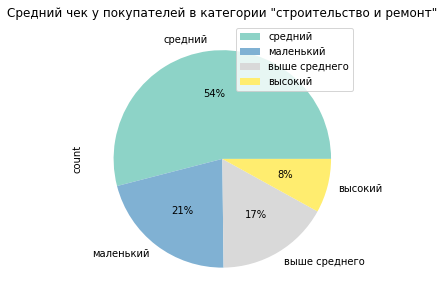

In [99]:
purchase_repair.plot(y='count', kind='pie', 
                     autopct = '%.0f%%', 
                     figsize=(5, 5), colormap='Set3')
plt.title('Средний чек у покупателей в категории "строительство и ремонт"')
plt.show() 

In [100]:
# сумма выручки по категориям чеков

repair.groupby('purchase').agg({'total': 'sum'}).reset_index()

,purchase,total
0,высокий,"53,354.00"
1,выше среднего,"66,263.00"
2,маленький,"3,632.00"
3,средний,"71,836.00"


Снова доля покупателей с крупным чеком значительно ниже остальных, всего 8%, и денег они принесли не так много, как покупатели со средним и выше среднего. Но и нижняя граница чека выше, чем в других категориях - 3800, а разброс между минимальным чеком и крупным сильно больше. Основу выручки составляют весомые покупки вроде стремянок, и мелкооптовые партии скобяных изделий . 1/5 всех клиентов в этой группе с маленьким чеком, до 200 рублей, и по сравнению с другими группами это довольно мало.

**Вывод**

Около половины покупателей во всех категориях со средним чеком, но сумма чека сильно отличается по категориям товаров, и клиенты, имеющие средний чек например в категории "растения для дома и сада" приносят в три раза меньше выручки, чем покупатели хозяйственных товаров для дома и быта.  

Даже высокий чек в категории растения такой низкий и составляет всего 1/5 от всех продаж, что наверняка магазин больше тратит на упаковку и логистику, чем получает прибыли с одного заказа. Очевидно, что покупатели совершают много мелких разовых заказов вместо крупных закупок. Нужно работать над увеличением чека за счет дополнительных продаж, чтобы те, кто покупают растения, сразу заказывали сопутствующие товары - садовый инвентарь, кашпо, удобрения и т.д.

В категории хозяйственно-бытовых товаров для дома тоже проблема со средним чеком - пятая часть клиетов сделали покупки на сумму менее 400р, а значит также разово заказывали дешевые товары, вместо того, чтобы закупаться всем необходимым. Например, в датасете достаточно данных о заказах товаров для стирки и уборки, но мало бытовой химии которая как раз бы могла быть дополнительным продуктом. 

Крупный чек во всех группах на уровне 7-9%, исключение - декор и текстиль, спасибо оптовым закупщикам, это единственная группа, где он достигает почти 20% от всех клиентов. Количество покупателей в группах с крупным чеком и маленьким соизмеримо, поэтому очень большой разброс между выручкой в этих группах. В этой категории тоже достаточно покупателей, сделавших мелкие недорогие заказы. В датасете очень много данных о покупках муляжей и искусственных цветов, в том числе и поштучно, но где остальной декор? Картины, свечи, постеры, вызы, остальной текстиль вроде декоративных подушек. Похоже, что потенциальные клиенты берут все это в других магазинах, а сюда приходят например влядельцы риэлторских агентств или декораторы, которые оформляют квартиры для сдачи/продажи.

Покупателей в категориях товаров для кухни и для строительства и ремонта значительно меньше, чем в других, поэтому и выручка здесь тоже меньше. В датасете довольно маленький ассортимент инструментов и скобяных изделий, а значит снова клиент почему-то не кладет в корзину сопутствующие товары. 

### Сегментация покупателей по заказам в будни/выходные

На основе анализа заказов по общим продажам и единицам мы уже знаем, что самая высокая выручка в начале недели, и к выходным активность покупателей снижается, достигая минимума в субботу. 

Посмотрим, есть ли отличия в среднем чеке у тех, кто заказывает по будням и тех, кто оформляет заказ в выходные.

In [101]:
# напишем функцию, которая определит день недели как будни или выходные 

def part_of_week(day_of_week):
    if day_of_week == 'Saturday' or day_of_week == 'Sunday':
        return 'выходной'
    else:
        return 'будний день'
    
ecom['part_of_week'] = ecom['day_of_week'].apply(part_of_week)   

In [102]:
# сгруппируем по категориям и будням/выходным, посчитаем среднюю выручку

part_of_week = ecom.groupby(
    ['part_of_week', 'category'])['total'].mean().reset_index().sort_values(by='category')
 
part_of_week

,part_of_week,category,total
0,будний день,бытовая техника,984.74
7,выходной,бытовая техника,"1,334.00"
1,будний день,декор и текстиль,"1,136.10"
8,выходной,декор и текстиль,564.59
2,будний день,комнатные и садовые растения,213.62
9,выходной,комнатные и садовые растения,185.85
3,будний день,мебель,"2,273.41"
10,выходной,мебель,"2,880.40"
4,будний день,строительство и ремонт,"1,235.20"
11,выходной,строительство и ремонт,"1,420.03"


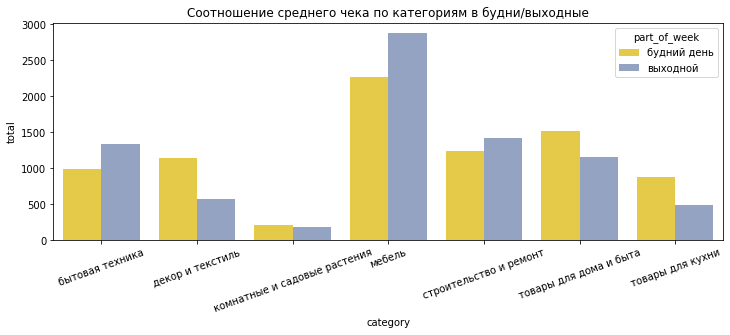

In [103]:
plt.figure(figsize = (12, 4))

ax = sns.barplot(x='category', y='total', 
                 hue='part_of_week', data=part_of_week, 
                 palette='Set2_r')
ax.set_title('Cоотношение среднего чека по категориям в будни/выходные')
plt.xticks(rotation=20)
plt.show()

Средний чек у мебели, бытовой техники и товаров для строительства и ремонта выше в выходные - это может быть связано с тем, что в первых двух группах обычно самые дорогие товары, которые требуют большего количества времени и в целом вдумчивого выбора и сравнения. В остальных категориях в среднем сумма заказа в будни выше, и как мы помним по дневному пику активности продаж, может быть связано с тем, что декор, хозяйственные товары и товары для кухни покупают например в обеденный перерыв в рабочее время. Тажке самый высокий пик продаж - в понедельник может быть связан с тем, что на выходных покупатели неспешно выбирают товары и кладут в корзину, а уже оформляют заказ в начале недели.

## Формулировка и проверка гипотез

### Гипотеза №1


**Средние чеки покупателей в будни и выходные равны**

**H0:** Средний чек покупателя в будни и выходные не отличается

**H1:** Средний чек покупателя в будни и выходные отличается

Заказы, сделанные в будни и выходные - разные, потому что один и тот же номер заказа не может быть оформлен сразу в два разных дня, а дубликаты по дате мы удалили в предобработке. Следовательно, у нас две независимые выборки, поэтому используем метод проверки гипотезы о равенстве средних двух разных выборок. 

In [104]:
# сформируем выборки с выручкой в будние и выходные дни

weekday = ecom.query('part_of_week == "будний день"')['total']

weekend = ecom.query('part_of_week == "выходной"')['total']

In [105]:
# проводим t-тест

alpha = 0.05

# используем параметр equal_var = False, так как мы знаем, 
# что выборки не равны - продаж в будни больше

results = st.ttest_ind(weekday, weekend, equal_var = False)

display('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    display('Отвергаем нулевую гипотезу')
else:
    display('Не получилось отвергнуть нулевую гипотезу') 

'p-значение:'

0.00019249830952062274

'Отвергаем нулевую гипотезу'

In [106]:
# посмотрим данные о среднем чеке в будни/выходные

ecom.groupby('part_of_week').agg({'total': 'mean'}).reset_index()

,part_of_week,total
0,будний день,746.53
1,выходной,590.82


Значение p-value говорит о том, что вероятность, что полученный результат - случайность, крайне мала. А значит можно сделать вывод о значимом различии между средними чеками. Группировка по среднему чеку в будни и выходные показывает, что действительно, между чеками есть существенная разница.

### Гипотеза №2

Распределения категорий для среднего чека в группах товаров для кухни и декора выглядят приближенными по значениям. Но у товаров для кухни нижняя граница крупного чека выше, а у декора и текстиля больше покупателей с крупным чеком по количеству. И там и там есть клиенты - оптовые закупкщики. Проверим, есть ли отличие в среднем чеке в этих категориях.

**Средняя сумма заказа у покупателей в "категориях товары для кухни" и "декор и текстиль" одинаковая**

**H0:** Средний чек покупателей в категориях "товары для кухни" и "декор и текстиль" не отличается

**H1:** Средний чек покупателей в категориях "товары для кухни" и "декор и текстиль" отличается

In [107]:
# сформируем выборки с выручкой двух групп товаров

data_kitchen = kitchen['total']

data_decor = decor['total']

In [108]:
# проводим t-тест

alpha = 0.05

# используем параметр equal_var = False, так как мы знаем, 
# что выборки не равны - заказов в категории декор и текстиль больше

results = st.ttest_ind(data_kitchen, data_decor, equal_var = False)

display('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    display('Отвергаем нулевую гипотезу')
else:
    display('Не получилось отвергнуть нулевую гипотезу') 

'p-значение:'

0.15309153337068454

'Не получилось отвергнуть нулевую гипотезу'

Значение p-value показывает: вероятность случайно получить такой результат равна 15%. Это довольно  большая вероятность, чтобы делать вывод о значимом различии между средними чеками. То есть средний чек покупателей в категориях "товары для кухни" и "декор и текстиль" существенно не отличается.

## Выводы и рекомендации

В ходе предобработки были удалены 28% данных, содержавших неявные дубликаты. Скорей всего это отмененные заказы/непрошедшие транзакции или что-то подобное. Также был удален один заказ с явным выбросом - оптовая закупка в 1000 вантузов, так как он слишком выбивался из ряда других оптовых заказов по сумме и количеству. Такие заказы очевидно большая редкость для нормального распределения заказов, поэтому от него избавились. 

Для дальнейших расчетов добавили столбцы с часами покупок, днями недели, месяцем и годом, а также данные с общей стоимостью заказа. По графику продаж по часам поведение потребителя выглядит вполне предсказуемым: низкая активность в ночное время и рано уторм, дневной пик в обеденный перерыв и небольшой всплеск вечером. Графики продаж по дням недели показали, что самый продуктивный по числу заказов - понедельник, а по сумме - вторник, к выходным активность клиентов снижается, возможно пототому, что на выходных они неспешно собирают корзину, а в понедельник-вторник оформляют заказ. Либо шопятся в физических магазинах, оставляя онлайн-шоппинг на будни. Проверка гипотезы различия средних чеков в будни и выходные показала, что в будни сумма заказа в среднем выше, чем в выходные.

Данные за 2018 год неполные - мы имеем только информацию о последних трех месяцах года, а данные за 2019 тоже не включают целый год и заканчиваются с октябрем. Поэтому за исключением октября 2018 и 2019 нет возможности сравнить продажи по месяцам за два года и сделать выводы о колебаниях и различиях помесячно. Однако мы видим, что октябрь 2019 значительно просел по сравнению с октябрем предыдущего года, и ни один месяц в 2019 году не достиг того же показателя по продажам, как конец 2018. В апреле и мае есть всплекс по числу заказов, что связано с началом дачного сезона, однако после EDA по группам товаров мы видим, что растения приносят примерно в 3,5 раза меньше выручки, чем лидер категорий - хозяйственные товары для дома и быта. 

Учитывая все это, налицо тревожная тенденция снижения продаж интернет-магазина, это в первую очередь может быть связано с тем, что 95% покупателей в датасете одноразовые, то есть совершали только один заказ за период год и один месяц, и скорей всего уже не вернутся. Значит, есть негативный опыт пользования услугами магазина, который может включать что угодно - от неудобного интерфейса, плохого ассортимента или неконкуретных цен до сроков доставки или взаимодействия с курьерской службой. Необходимо изучить клиентский опыт использования сервиса путем опросов, проведением "тайного покупателя" и т.д. Магазину «Пока все ещё тут» требуется не только аналитик, но и маркетолог, или вообще кризис-менеджер, потому что одними персональлизированными предложениями ситуацию не спасти.

В целом можно сказать, что магазин держится на плаву за счет мелкооптовых покупателей сумок-тележек, простыней, ножей и т.д. При этом основу ассортимента составляют растения, по единицам они продаются лучше остальных товаров, но как уже было сказано, это не самая прибыльная категория и там самый низкий средний чек. Нужно работать над его увеличением путем увеличения числа единиц в заказе. В датасете отсутсвуют данные о продажах сопутсвующих товаров в этой группе - скорей всего этих товаров там просто нет. Люди заказывают растения в большом количестве, но у них нет возможности добавить в заказа дополнительные товары для садоводства и выращивания комнатных растений - лейки, опрыскиватели, кашпо и горшки, стойки и опоры для цветов, инструменты для обрезки и т.д. 

Аналогичная ситуация и в других категориях - нет дополнительных и кросс-продаж, только 15% заказов содержат больше 1 единицы разных категорий товаров. В категории хозяйственных товаров мало данных о заказах бытовой химии, в категории декор и текстиль - предметов для оформления интерьера. Все это говорит о скудном ассортименте и о том, что потенциальные клиенты не совершают покупки потому, что магазину нечего им предложить.

В связи с этими выводами по исследованию для поднятия можно предложить придерживаться одной из трех стратегий:

- Расширение ассортимента всех категорий товаров. Чтобы покупательский опыт формировался как при посещении IKEA - когда ты заходишь за роликом для чистки одежды, а выходишь с полной тележкой, где и посуда, и тестиль и т.д. То есть чтобы у пользователя была возможность добавить и сопутствующие товары, и нужные (или не очень) вещи из других групп товаров.

- Напротив, выбрать специализацию и сосредоточиться на ней, расширив категрию товаров внутри этой группы. Продажи по единицам показывают, что это может быть садоводство и выращивание комнатных растений, продажи по сумме - что хозяйственные товары. В датасете есть и мебель, и бытовая техника, при этом очевидно, что интернет-магазин не выдерживает конкуренции с гигантами рынка, типа той же Икеи, Оби или даже Алиэкспресса, где можно купить всю свою жизнь. 

- Оптовые закупки специфических товаров типа муляжей, искуственных цветов, ножей и простыней говорят о том, что у интернет-магазина есть какая-то особая группа клиентов, но мы не располагаем дополнительной информацией, чтобы сделать какие-то конкретные выводы. Похоже, что это могут быть владельцы мелкого бизнеса вроде риэлторских агентств, предоставляющих услуги стейджинга или собственники апартаментов под кратковременную сдачу. В сязи с этим можно попробовать собрать больше данных на сайте путем заполнения небольшой анкеты (за небольшую скидку, чтобы гарантировать больший охват) и сегментировать товары и персонализировать предложения для таких покупателей. 

**Рекомендации по дальнейшему сбору и работе с данными:**

- присваивать каждому товару персональный идентификатор для более удобной категоризации
- добавить колонку о статусе транзакции(оплачено/заказ отменен) для того, чтобы в датасете остутствовали дубликаты и все заказы были уникальные